In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
database = "Resources\hawaii.sqlite"
engine = create_engine(f"sqlite:///{database}")
conn = engine.connect()

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurements = Base.classes.measurement
Stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Inspect table for column names 
columns_m = inspector.get_columns('measurement')
for columns in columns_m:
    print(columns["name"], columns["type"])

print("-----------")

columns_s = inspector.get_columns('station')
for column in columns_s:
    print(column['name'], column['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis 

In [9]:
# Find the most recent date in the data set.
for date in session.query(func.max(Measurements.date,)):
    print(f'Most recent date in the data set: {date}')

Most recent date in the data set: ('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
prcp_recent = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
prcp_year = prcp_recent - dt.timedelta(days=365)
print(f'Date, one year from most recent: {prcp_year}')

# Perform a query to retrieve the data and precipitation scores
prcp_year_total = session.query(Measurements.date, Measurements.prcp). \
    filter(Measurements.date >= prcp_year).all()
#print(prcp_year_total)

# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_12_months_df = pd.DataFrame(prcp_year_total, columns=['date', 'precipitation'])
prcp_12_months_df = prcp_12_months_df.sort_values("date")
prcp_12_months_df

# Sort the dataframe by date
#prcp_12_months_df_sorted = prcp_12_months_df.sort_values('date')
#prcp_12_months_df_sorted

Date, one year from most recent: 2016-08-23


,date,precipitation
0,2016-08-23,0.00
1009,2016-08-23,NaN
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


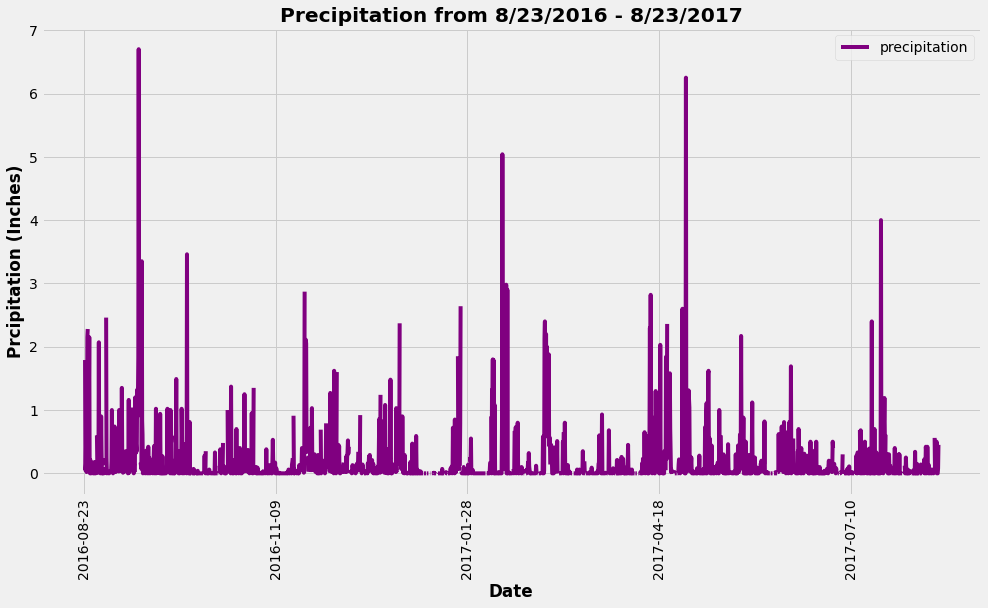

In [28]:
# Use Pandas Plotting with Matplotlib to plot the data
prcp_plot = prcp_12_months_df.plot(x='date', y='precipitation', rot=90, figsize=(15, 8), color='purple')
prcp_plot.set_xlabel("Date", weight="bold")
prcp_plot.set_ylabel("Prcipitation (Inches)", weight="bold")
prcp_plot.set_title("Precipitation from 8/23/2016 - 8/23/2017", weight="bold")
plt.show()

In [20]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_12_months_stats = prcp_12_months_df["precipitation"].describe()
prcp_12_months_stats_df = pd.DataFrame(prcp_12_months_stats)
prcp_12_months_stats_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [21]:
# Design a query to calculate the total number stations in the dataset
station_total = session.query(Stations.name).count()
print(f"Total number of stations: {station_total}")

Total number of stations: 9


In [22]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
station_count = session.query(Measurements.station, Stations.name,
                                 func.count(Measurements.station)). \
                   filter(Measurements.station == Stations.station). \
                   group_by(Measurements.station)

active_stations = pd.DataFrame(station_count, columns =["Station ID", "Station Name/Location", "Count of Active Stations"])
active_stations_sorted = active_stations.sort_values(by = "Count of Active Stations", ascending=False).reset_index()
active_stations_sorted

,index,Station ID,Station Name/Location,Count of Active Stations
0,6,USC00519281,"WAIHEE 837.5, HI US",2772
1,7,USC00519397,"WAIKIKI 717.2, HI US",2724
2,1,USC00513117,"KANEOHE 838.1, HI US",2709
3,8,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",2669
4,3,USC00516128,"MANOA LYON ARBO 785.2, HI US",2612
5,2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",2202
6,0,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",1979
7,4,USC00517948,"PEARL CITY, HI US",1372
8,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",511


In [23]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
lowest_temp = session.query(func.min(Measurements.tobs)).\
    filter(Measurements.station == "USC00519281")

highest_temp = session.query(func.max(Measurements.tobs)). \
    filter(Measurements.station == "USC00519281")

average_temp = session.query(func.avg(Measurements.tobs)). \
    filter(Measurements.station == "USC00519281")

print(f' The Lowest tempurature for the most active station: {lowest_temp.first()[0]}.')
print(f' The Highest tempurature for the most active station is {highest_temp.first()[0]}.')
print(f' The Average tempurature for the most active station is {round(average_temp.first()[0],1)}.')

 The Lowest tempurature for the most active station: 54.0.
 The Highest tempurature for the most active station is 85.0.
 The Average tempurature for the most active station is 71.7.


In [24]:
# Get most recent date of measurements for the most active station
most_active_recent = session.query(func.max(Measurements.date)). \
    filter(Measurements.station == "USC00519281")
print(most_active_recent.first()[0])

recent_tobs_date = dt.date(2017, 8, 18)

most_recent_year_tobs = recent_tobs_date - dt.timedelta(days=365)
print(f'Date, one year from most recent measurement at most active station: {most_recent_year_tobs}')

2017-08-18
Date, one year from most recent measurement at most active station: 2016-08-18


In [25]:
# Query the last 12 months of temperature observation data for this statio
tobs_most_active_year = session.query(Measurements.tobs). \
    filter(Measurements.station == 'USC00519281'). \
    filter(Measurements.date >= most_recent_year_tobs).all()
#print(tobs_most_active_year)

# Create dataframe of results 
tobs_most_active_year_df = pd.DataFrame(tobs_most_active_year, columns=['tobs'])
tobs_most_active_year_df

,tobs
0,80.0
1,79.0
2,81.0
3,79.0
4,78.0
...,...
352,77.0
353,77.0
354,76.0
355,76.0


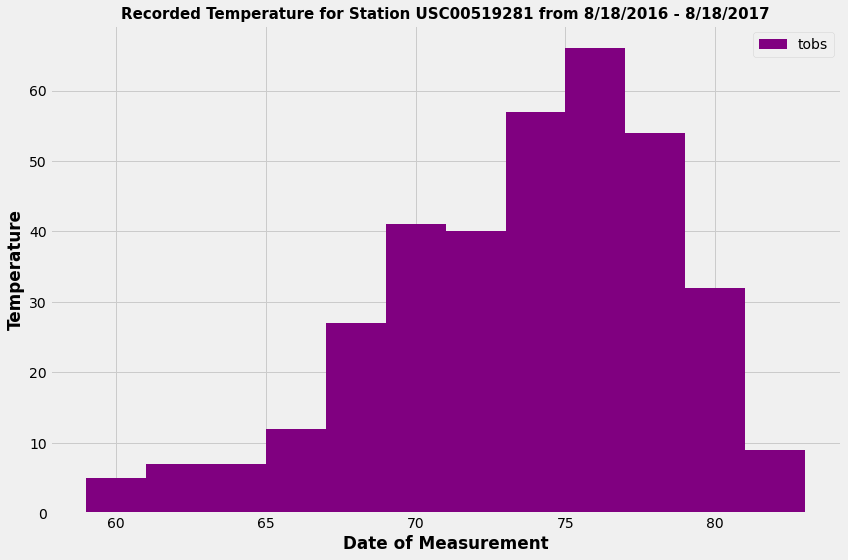

In [27]:
from pandas.plotting import table 

# Plot the results as a histogram
tobs_most_active_year_df.plot.hist(color = "purple", bins = 12, figsize = (12,8))

plt.title("Recorded Temperature for Station USC00519281 from 8/18/2016 - 8/18/2017", weight = "bold", size = 15)
plt.xlabel("Date of Measurement", weight = "bold")
plt.ylabel("Temperature", weight = "bold")
plt.tight_layout()
plt.show()

# Close session

In [30]:
# Close Session
session.close()